In [7]:
import pandas as pd
import numpy as np

# --- STEP 1: DEFINE THE COLUMN NAMES BASED ON README ---
# Columns 1 & 2: ID and Cycle
index_names = ['unit_nr', 'time_cycles']

# Columns 3, 4, 5: Operational Settings
setting_names = ['setting_1', 'setting_2', 'setting_3']

# Columns 6 to 26: Sensors (There are 21 sensors total)
sensor_names = ['s_{}'.format(i) for i in range(1, 22)] 

# Combine them all
col_names = index_names + setting_names + sensor_names

# --- STEP 2: LOAD THE TRAINING DATA ---
# We use sep='\s+' because the text file uses spaces, not commas
train_df = pd.read_csv('../data/raw/train_FD001.txt', sep=r'\s+', header=None, names=col_names)

# --- STEP 3: CALCULATE RUL (TARGET VARIABLE) ---
# Since Training data runs to failure, RUL = Max Cycle - Current Cycle

def add_rul(df):
    # Get the last cycle for each unit (that's when it failed)
    max_cycles = df.groupby('unit_nr')['time_cycles'].max().reset_index()
    max_cycles.columns = ['unit_nr', 'max_cycle']
    
    # Merge max_cycle back to the original frame
    df = df.merge(max_cycles, on='unit_nr', how='left')
    
    # Calculate RUL
    df['RUL'] = df['max_cycle'] - df['time_cycles']
    
    # Drop the helper column
    df.drop('max_cycle', axis=1, inplace=True)
    return df

train_df = add_rul(train_df)

# --- STEP 4: VERIFY ---
print(f"Data Loaded! Shape: {train_df.shape}")
print(train_df[['unit_nr', 'time_cycles', 's_1', 's_2', 'RUL']].head())

Data Loaded! Shape: (20631, 27)
   unit_nr  time_cycles     s_1     s_2  RUL
0        1            1  518.67  641.82  191
1        1            2  518.67  642.15  190
2        1            3  518.67  642.35  189
3        1            4  518.67  642.35  188
4        1            5  518.67  642.37  187


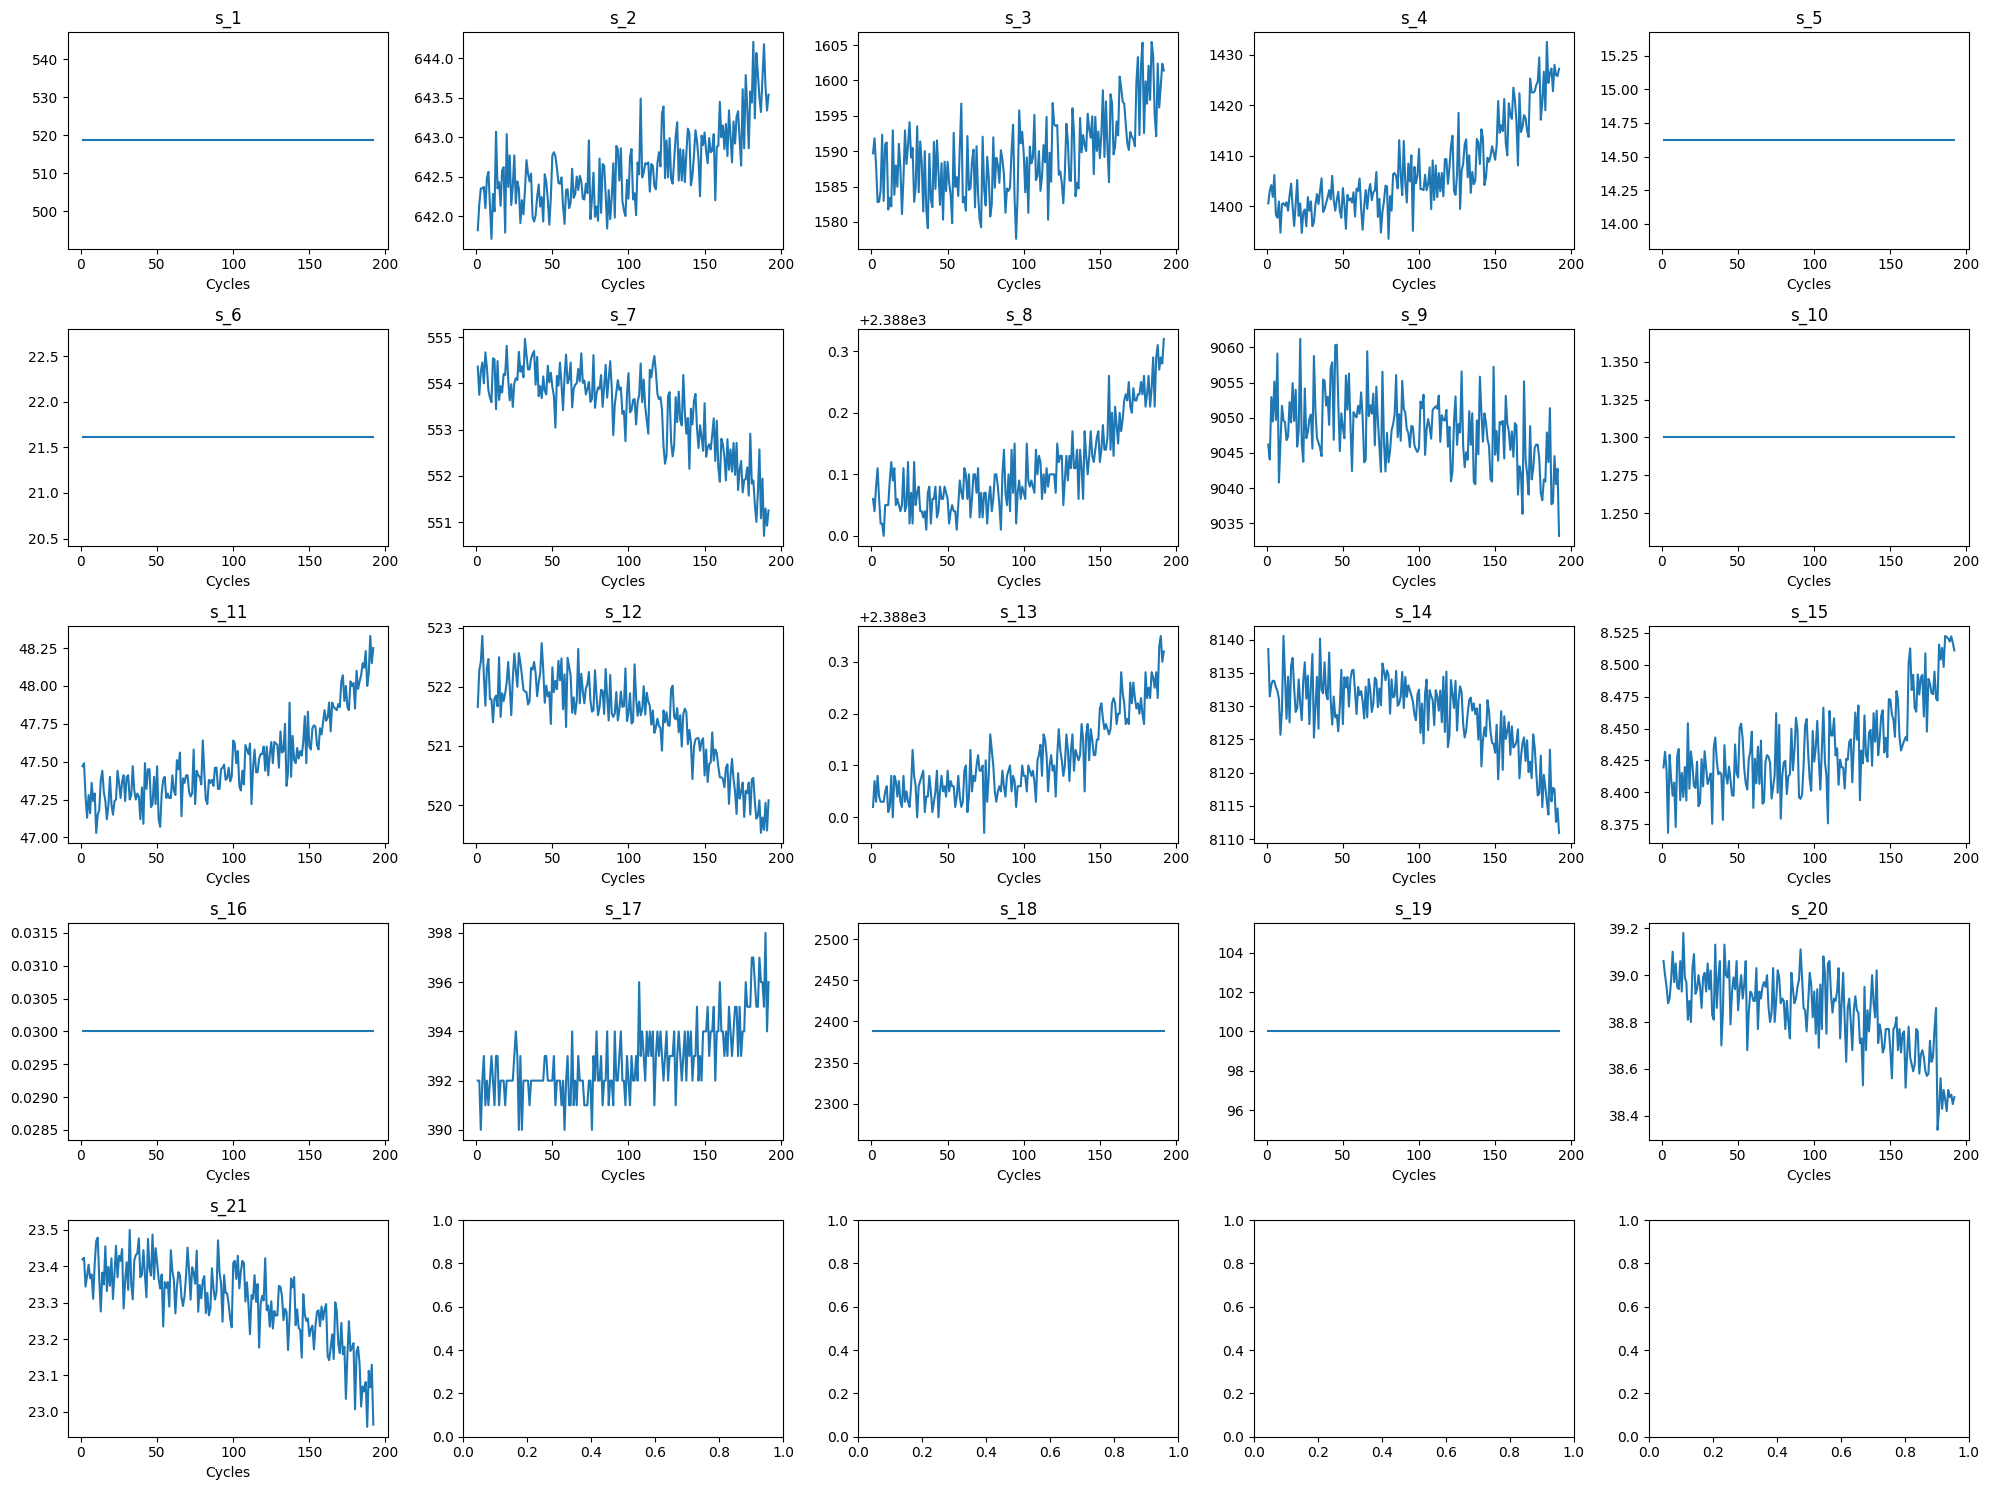

In [8]:
import matplotlib.pyplot as plt

def plot_sensor_trends(df, unit_id=1):
    # Setup a grid of plots (5 rows, 5 columns)
    fig, axes = plt.subplots(5, 5, figsize=(20, 15))
    axes = axes.ravel() # Flatten the grid so we can loop over it easily

    # Loop through sensors s_1 to s_21
    for i in range(1, 22):
        sensor_col = f's_{i}'
        
        # Plot the data for the specific unit
        subset = df[df['unit_nr'] == unit_id]
        axes[i-1].plot(subset['time_cycles'], subset[sensor_col])
        
        axes[i-1].set_title(sensor_col)
        axes[i-1].set_xlabel('Cycles')

    plt.tight_layout()
    plt.show()

plot_sensor_trends(train_df)

In [9]:
train_df.head() 
#Total Columns: 1 (Unit) + 1 (Time) + 3 (Settings) + 21 (Sensors) = 26 Columns.

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [10]:
# Based on our visual inspection of FD001:
# Sensors that are flat (std dev is 0 or close to 0)
cols_to_drop = ['s_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19']

# Also droping the "Setting" columns, as FD001 has only ONE setting (Sea Level)
cols_to_drop += ['setting_1', 'setting_2', 'setting_3']

print(f"Dropping {len(cols_to_drop)} columns: {cols_to_drop}")

# Creating a new clean dataframe
train_df_clean = train_df.drop(columns=cols_to_drop)

print(f"New Shape: {train_df_clean.shape}")
train_df_clean.head()

Dropping 10 columns: ['s_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19', 'setting_1', 'setting_2', 'setting_3']
New Shape: (20631, 17)


,unit_nr,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,RUL
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187


In [11]:
def add_rolling_features(df, sensors, window_size=5):
    # Create a copy so we don't mess up the original
    df_roll = df.copy()
    
    # Calculate Rolling Mean and Std for each sensor
    for sensor in sensors:
        # We group by 'unit_nr' because we don't want the window to 
        # accidentally mix data from Engine 1 and Engine 2!
        
        # 1. Rolling Mean (The Trend)
        df_roll[f'{sensor}_mean'] = df.groupby('unit_nr')[sensor].transform(
            lambda x: x.rolling(window=window_size).mean()
        )
        
        # 2. Rolling Std (The Instability/Vibration)
        df_roll[f'{sensor}_std'] = df.groupby('unit_nr')[sensor].transform(
            lambda x: x.rolling(window=window_size).std()
        )
    
    # Important: The first 4 rows of every engine will be NaN (empty)
    # because they don't have 5 previous cycles to average.
    # We must drop them.
    df_roll.dropna(inplace=True)
    
    return df_roll

# Define the sensors we kept (The "Trenders")
# Note: make sure these match the columns you actually kept!
sensors_to_roll = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']

# Apply the function
train_df_final = add_rolling_features(train_df_clean, sensors_to_roll)

print(f"Original Shape: {train_df_clean.shape}")
print(f"New Shape: {train_df_final.shape}")
print("Columns added:", [c for c in train_df_final.columns if 'mean' in c or 'std' in c])

train_df_final.head()

Original Shape: (20631, 17)
New Shape: (20231, 45)
Columns added: ['s_2_mean', 's_2_std', 's_3_mean', 's_3_std', 's_4_mean', 's_4_std', 's_7_mean', 's_7_std', 's_8_mean', 's_8_std', 's_9_mean', 's_9_std', 's_11_mean', 's_11_std', 's_12_mean', 's_12_std', 's_13_mean', 's_13_std', 's_14_mean', 's_14_std', 's_15_mean', 's_15_std', 's_17_mean', 's_17_std', 's_20_mean', 's_20_std', 's_21_mean', 's_21_std']


,unit_nr,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,...,s_14_mean,s_14_std,s_15_mean,s_15_std,s_17_mean,s_17_std,s_20_mean,s_20_std,s_21_mean,s_21_std
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,...,8134.194,2.651326,8.41334,0.025953,391.8,1.095445,38.958,0.073621,23.39302,0.033498
5,1,6,642.10,1584.47,1398.37,554.67,2388.02,9049.68,47.16,521.68,...,8133.040,0.958697,8.41160,0.025727,391.6,1.140175,38.942,0.051186,23.38260,0.031436
6,1,7,642.48,1592.32,1397.77,554.34,2388.02,9059.13,47.36,522.32,...,8133.206,0.643141,8.40472,0.023476,391.6,1.140175,38.962,0.086718,23.37336,0.021634
7,1,8,642.56,1582.96,1400.97,553.85,2388.00,9040.80,47.24,522.47,...,8132.774,1.149274,8.40268,0.022477,391.8,0.836660,38.966,0.086487,23.36664,0.034405
8,1,9,642.12,1590.98,1394.80,553.69,2388.05,9046.46,47.29,521.79,...,8131.146,3.205438,8.40360,0.020740,391.8,0.836660,39.000,0.077136,23.37318,0.038939


In [12]:
train_df_final.columns

Index(['unit_nr', 'time_cycles', 's_2', 's_3', 's_4', 's_7', 's_8', 's_9',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21', 'RUL',
       's_2_mean', 's_2_std', 's_3_mean', 's_3_std', 's_4_mean', 's_4_std',
       's_7_mean', 's_7_std', 's_8_mean', 's_8_std', 's_9_mean', 's_9_std',
       's_11_mean', 's_11_std', 's_12_mean', 's_12_std', 's_13_mean',
       's_13_std', 's_14_mean', 's_14_std', 's_15_mean', 's_15_std',
       's_17_mean', 's_17_std', 's_20_mean', 's_20_std', 's_21_mean',
       's_21_std'],
      dtype='str')

In [13]:
import os

# Create the processed directory if it doesn't exist
os.makedirs('../data/processed', exist_ok=True)

# Save the final dataframe to CSV
# index=False means "don't save the row numbers 0,1,2..."
train_df_final.to_csv('../data/processed/train_FD001_clean.csv', index=False)

print("Data saved successfully to ../data/processed/train_FD001_clean.csv")

Data saved successfully to ../data/processed/train_FD001_clean.csv
